In [143]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sotodlib import core
import sotodlib.io.load as io_load

from moby2.analysis import socompat
socompat.register_loaders()

In [144]:
### This is used for .g3 files that are not part of an observation database
#fname = '/mnt/so1/shared/todsims/pipe-s0001/v4/datadump_LAT_MFF1/CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-0-0/MFF1_wafer_13_00000000.g3'
fname = '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4/datadump_LAT_MFF1/CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-0-0/MFF1_wafer_13_00000000.g3'
tod = io_load.load_file(fname)

In [145]:
%%writefile simons1_pipe_s0001_v4.yaml
tags:
    sim_base_dir: '/mnt/so1/shared/todsims/pipe-s0001/v4'
    meta_dir:     '/mnt/so1/shared/todsims/pipe-s0001/v4'

obsfiledb:  '{meta_dir}/obsfiledb.sqlite'
detdb:      '{meta_dir}/detdb_lat.gz'
obsdb:      '{meta_dir}/obsdb.gz'

obs_colon_tags: ['band', 'wafer', 'fcode']
obs_loader_type: 'pipe-s0001'

metadata:
  - db: '{meta_dir}/focalplane.gz'
    name: "focal_plane"

Overwriting simons1_pipe_s0001_v4.yaml


In [146]:
nersc_todsims = '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4/context.yaml'
nersc_actpol = '/global/project/projectdirs/sobs/users/mhasse/actpol_demo/uranus_200327/metadata/context.yaml'

In [147]:
context = core.Context(nersc_todsims)
#context = core.Context('simons1_pipe_act_uranus.yaml')

In [148]:
## This returns a ResultSet that lists all the observations in the observation database
obs_list = context.obsdb.get()

print("There are {} observations currently in the database".format(len(obs_list)))

## Choose a random observation from the database
# x = np.random.randint(len(obs_list))
x = 138
my_obs = obs_list[x]

## We might want to know things able the observation we are looking at
print("Observation: {}".format(my_obs['obs_id']))
for k in my_obs:
    if k == 'obs_id':
        continue
    print('\t', k,':', my_obs[k])

There are 380 observations currently in the database
Observation: CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-21-0_MFF
	 timestamp : 1626614093.009091
	 drift : setting
	 az_min : -141.84857751648792
	 az_max : -128.821422483511
	 az_med : -135.4197826219584
	 el_min : 57.23000345371954
	 el_max : 60.22999654516515
	 el_med : 58.73
	 is_const_el : 0
	 is_const_az : 0
	 is_stare : 0


In [272]:
## Detector Sets are how the observation files are saved at the moment. 
det_sets = context.obsfiledb.get_detsets( my_obs['obs_id'] )
print('The different detector sets are: \n', det_sets)

dets = context.obsfiledb.get_dets(det_sets[0])
print('\nThe first 10 detectors of the first detector set are:\n',dets[:10])

### Just create a tod with n detectors
detector_nums = 3
tod = context.get_obs(my_obs, dets=dets[:detector_nums])

The different detector sets are: 
 ['MFF1_wafer_13', 'MFF1_wafer_14', 'MFF1_wafer_15', 'MFF1_wafer_16', 'MFF1_wafer_17', 'MFF1_wafer_18', 'MFF2_wafer_13', 'MFF2_wafer_14', 'MFF2_wafer_15', 'MFF2_wafer_16', 'MFF2_wafer_17', 'MFF2_wafer_18']

The first 10 detectors of the first detector set are:
 ['13_000_MFF1_A', '13_000_MFF1_B', '13_001_MFF1_A', '13_001_MFF1_B', '13_002_MFF1_A', '13_002_MFF1_B', '13_003_MFF1_A', '13_003_MFF1_B', '13_004_MFF1_A', '13_004_MFF1_B']


In [248]:
tod.signal

array([[9.576688 , 9.571351 , 9.576924 , ..., 9.774548 , 9.779385 ,
        9.78214  ],
       [9.5717535, 9.577461 , 9.577652 , ..., 9.775609 , 9.784497 ,
        9.781528 ],
       [9.567052 , 9.574424 , 9.571589 , ..., 9.774735 , 9.77947  ,
        9.766874 ]], dtype=float32)

In [249]:
sig_mean = np.mean( tod.signal, axis = 0)
tod.wrap('sig_mean', sig_mean, [(0,tod.samps)])

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], dets:LabelAxis(3), samps:OffsetAxis(214278))

In [250]:
tsamp = np.median(np.diff(tod.timestamps))
n_cut = int(10//tsamp)
print('Trimming in time...')

tod.restrict('samps', (n_cut, tod.samps.count-n_cut))
print('The TOD now has {} samples'.format(tod.samps.count))

Trimming in time...
The TOD now has 209878 samples


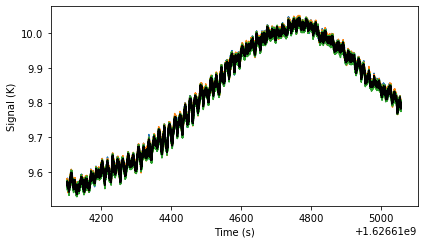

In [251]:
fig = plt.figure(figsize=(6,3.5))
for i in range(tod.dets.count):
    plt.plot(tod.timestamps, tod.signal[i])
if hasattr(tod, 'sig_mean'):
    plt.plot(tod.timestamps, tod.sig_mean, 'k-')
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

In [252]:
from sotodlib.core import FlagManager

import sotodlib.flags as flags
import sotodlib.sim_flags as sim_flags

import sotodlib.tod_ops.filters as filters

from sotodlib.tod_ops import fourier_filter, rfft, detrend_data

In [259]:
# add a glitch with a height
sim_flags.add_random_glitches(tod, params={'h_glitch':10}, signal='badness')

sotodlib.core.axisman.AxisManager

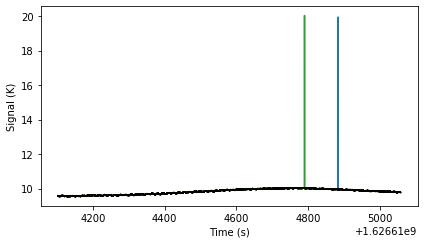

In [260]:
fig = plt.figure(figsize=(6,3.5))
for i in range(tod.dets.count):
    if not 'badness' in tod:
        plt.plot(tod.timestamps, tod.signal[i])
    else:
        plt.plot(tod.timestamps, tod.signal[i]+tod.badness[i])
if hasattr(tod, 'sig_mean'):
    plt.plot(tod.timestamps, tod.sig_mean, 'k-')
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

# remember tod is an AxisManager object(class)
type(tod)

In [261]:
# flags.get_glitch_flags uses fourier filtering translation from moby2 at starting point
found_glitches = flags.get_glitch_flags(tod, overwrite=True)
# flags.get_glitch_flags returns a RangesMatrix object of glitches
type(found_glitches)

so3g.proj.ranges.RangesMatrix

In [271]:
for i in found_glitches.ranges:
    print(i.ranges())

[[     0    209]
 [209668 209878]]
[[     0    207]
 [209669 209878]]
[[     0    209]
 [209670 209878]]


In [268]:
print(found_glitches.ranges[0].ranges())
print(found_glitches.ranges)
print(found_glitches.ranges[0])

[[     0    209]
 [209668 209878]]
[<so3g.RangesInt32 object at 0x2aab67c10c90>, <so3g.RangesInt32 object at 0x2aab67c101e8>, <so3g.RangesInt32 object at 0x2aab67c10608>]
Ranges(n=209878:rngs=2)


In [263]:
found_glitches.get_stats()

{'samples': [419, 416, 417], 'intervals': [2, 2, 2]}

In [220]:
# how many true glitches in tod?
n_t_glitch = np.sum([len(t.ranges()) for t in tod.flags.true_glitches])
print(n_t_glitch)

4


In [175]:
# find the glitches from tod signal
success_glitches = np.zeros((tod.dets.count))
for in range (tod.dets.count):
    if 
#Glitch = flags.get_glitch_flags(tod, params={'h_glitch': 80}, overwrite=True)
#type(Glitch)

In [139]:
tod.flags.true_glitches

RangesMatrix(1,209878)


In [246]:
if 'bad_signal' in tod:
    tod.move('bad_signal', None)

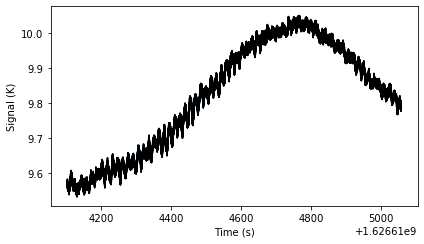

In [244]:
fig = plt.figure(figsize=(6,3.5))
for i in range(tod.dets.count):
    plt.plot(tod.timestamps, tod.signal[i])
if hasattr(tod, 'sig_mean'):
    plt.plot(tod.timestamps, tod.sig_mean, 'k-')
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()